In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Lambda, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.layers import Layer, Lambda, Concatenate

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data() 

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [4]:
print(f"X train shape:{X_train.shape}")
print(f"X test shape:{X_test.shape}")
print(f"y train shape:{y_train.shape}")
print(f"y test shape:{y_test.shape}")

X train shape:(50000, 32, 32, 3)
X test shape:(10000, 32, 32, 3)
y train shape:(50000, 1)
y test shape:(10000, 1)


<ipython-input-5-2d31486dc9e6>:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_index = int(y_train[index])


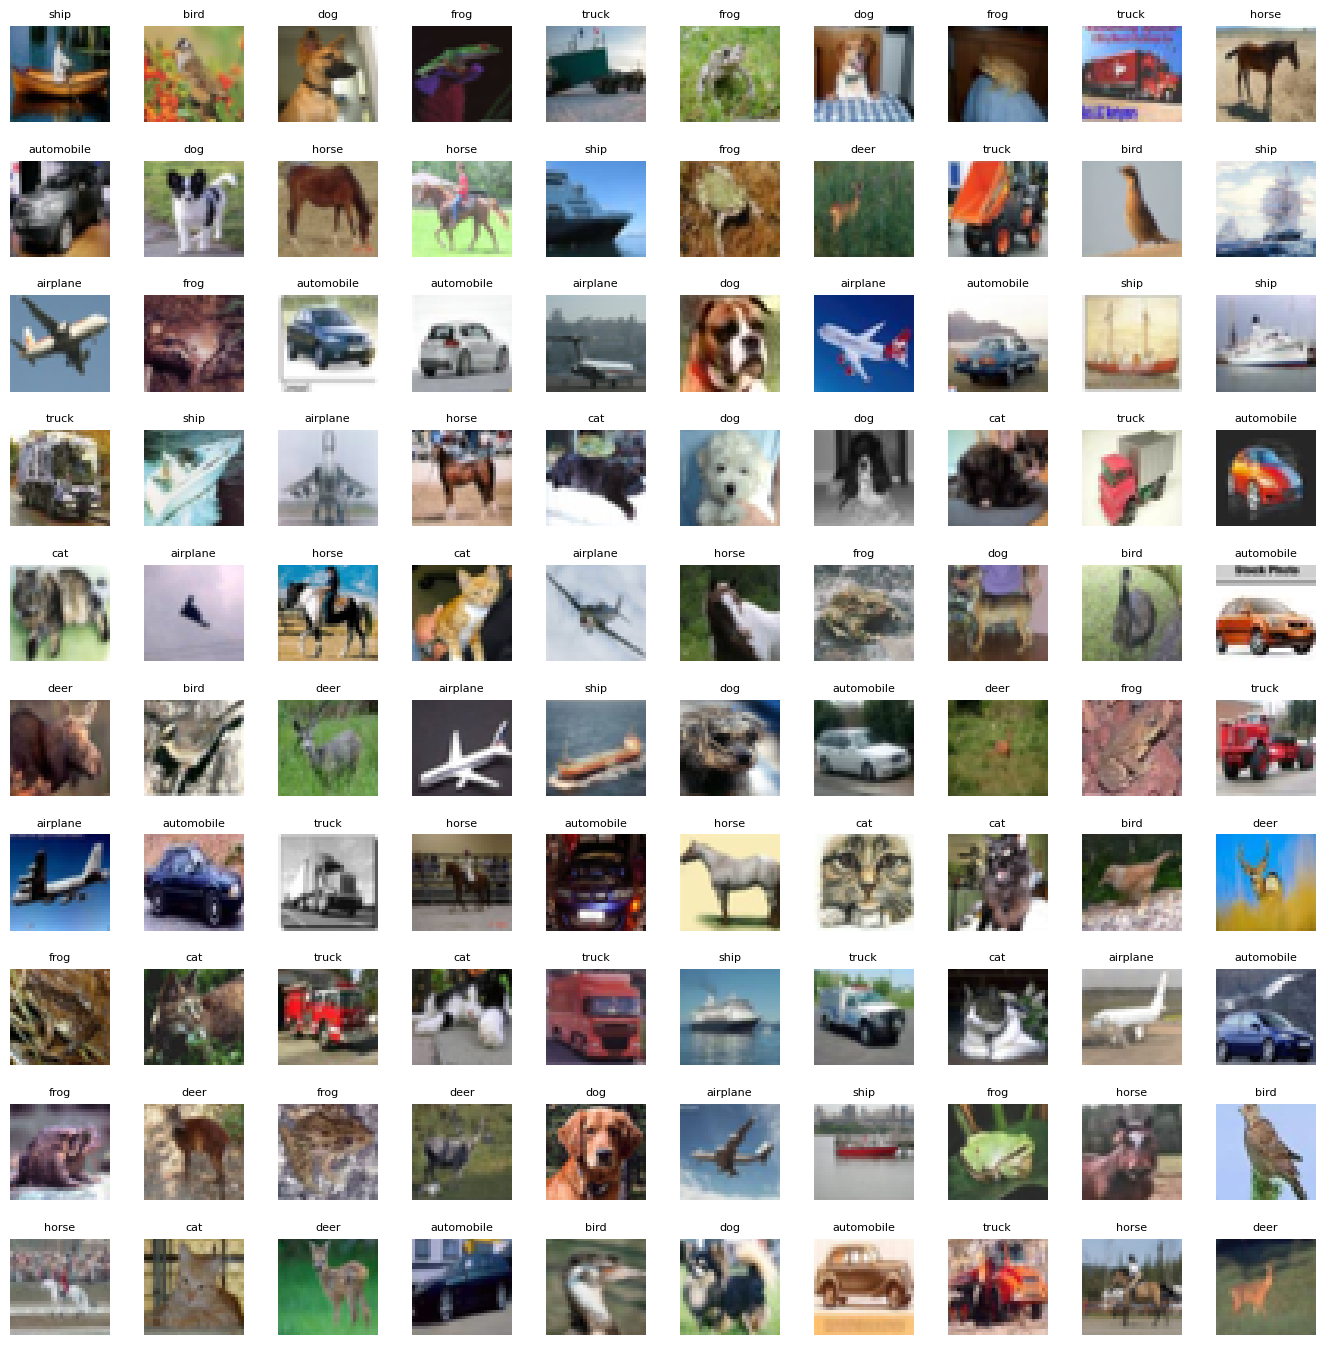

In [5]:
labels = ['airplane', 'automobile','bird','cat','deer','dog',
          'frog','horse','ship','truck']

width_grid = 10
len_grid = 10

fig,axes = plt.subplots(len_grid, width_grid, figsize = (17,17))

axes = axes.ravel() #flatten 15x15 matrix into 1d 225 element array

n_train = len(X_train)

for i in np.arange(0, width_grid*len_grid):
    #select random index
    index = np.random.randint(0, n_train)
    #read and display an image with the selected index
    axes[i].imshow(X_train[index, 1:])
    label_index = int(y_train[index])
    axes[i].set_title(labels[label_index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

Text(0.5, 1.0, 'Class distribution in train data')

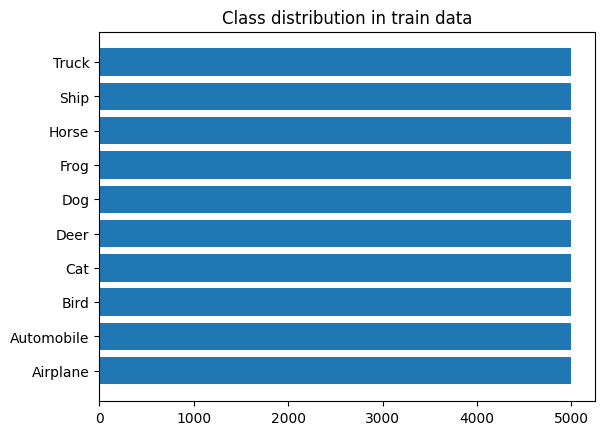

In [6]:
class_names = ['Airplane', 'Automobile','Bird','Cat','Deer','Dog',
          'Frog','Horse','Ship','Truck']

classes, counts = np.unique(y_train, return_counts=True)
plt.barh(class_names, counts)
plt.title('Class distribution in train data')

In [7]:
X_train = X_train / 255.0
X_test = X_test / 255.0

y_cat_train = to_categorical(y_train, 10)
y_cat_test = to_categorical(y_test, 10)


y_cat_train.dtype

dtype('float64')

In [8]:
def intermediate_block(x, filters, kernel_size, num_layers):
    conv_outputs = []
    for _ in range(num_layers):
        conv = Conv2D(filters=filters, kernel_size=kernel_size, padding='same', activation='relu')(x)
        conv_outputs.append(conv)

    conv_stack = Lambda(lambda tensors: tf.stack(tensors, axis=-1))(conv_outputs)  

    channel_avg = Lambda(lambda t: tf.reduce_mean(t, axis=[1, 2]))(x)  #shape- (B, C)

    weight_logits = Dense(num_layers)(channel_avg)
    weights = Lambda(lambda t: tf.nn.softmax(t, axis=-1))(weight_logits)  #shape- (B, L)

    weights_expanded = Lambda(lambda t: tf.reshape(t, (-1, 1, 1, 1, num_layers)))(weights)

    weighted_sum = Lambda(lambda args: tf.reduce_sum(args[0] * args[1], axis=-1))([conv_stack, weights_expanded]) #(B, H, W, C)

    return weighted_sum

def output_block(x, num_classes, hidden_units=256):
    channel_avg = GlobalAveragePooling2D()(x)
    dense1 = Dense(hidden_units, activation='relu')(channel_avg)
    dropout = Dropout(0.1)(dense1)
    output = Dense(num_classes, activation='softmax')(dropout)
    return output


In [9]:
def build_model(input_shape=(32, 32, 3), num_classes=10):
    inputs = Input(shape=input_shape)

    #Block 1
    x = intermediate_block(inputs, filters=128, kernel_size=(3, 3), num_layers=3)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)

    #Inter-block conv layer after B1
    x = Conv2D(64, (1, 1), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    #Block 2
    x = intermediate_block(x, filters=256, kernel_size=(3, 3), num_layers=3)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)

    #Inter-block conv layer after B2
    x = Conv2D(128, (1, 1), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    #Block 3
    x = intermediate_block(x, filters=256, kernel_size=(3, 3), num_layers=3)
    x = BatchNormalization()(x)
    x = Dropout(0.15)(x)

    #Output
    outputs = output_block(x, num_classes=num_classes)
    model = Model(inputs=inputs, outputs=outputs)
    return model


In [10]:
model = build_model()
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)         │ (None, 3)              │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 3)              │             12 │ lambda_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 128)    │          3,584 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 128)    │          3,584 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 128)    │          3,584 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_2 (Lambda)         │ (None, 3)              │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 32, 32, 128, 3) │              0 │ conv2d[0][0],          │
│                           │                        │                │ conv2d_1[0][0],        │
│                           │                        │                │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_3 (Lambda)         │ (None, 1, 1, 1, 3)     │              0 │ lambda_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_4 (Lambda)         │ (None, 32, 32, 128)    │              0 │ lambda[0][0],          │
│                           │                        │                │ lambda_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 32, 32, 128)    │            512 │ lambda_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 32, 32, 128)    │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 32, 64)     │          8,256 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 32, 32, 64)     │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_6 (Lambda)         │ (None, 64)             │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 3)              │            195 │ lambda_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 256)    │        147,712 │ batch_normalization_1… │
├──────────────────────

 Total params: 1,452,828 (5.54 MB)

 Trainable params: 1,451,164 (5.54 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [11]:
batch_size = 32
data_generator = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_generator = data_generator.flow(X_train, y_cat_train, batch_size=batch_size)
steps_per_epoch = X_train.shape[0] // batch_size

In [18]:
r = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=(X_test, y_cat_test),
    epochs=20
) # i ran this piece of code twice first with 40 epochs and then with 20

Epoch 1/20
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 48s 31ms/step - accuracy: 0.9333 - loss: 0.1850 - precision: 0.9438 - recall: 0.9243 - val_accuracy: 0.8437 - val_loss: 0.5852 - val_precision: 0.8584 - val_recall: 0.8325
Epoch 2/20
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9688 - loss: 0.1083 - precision: 0.9688 - recall: 0.9688 - val_accuracy: 0.8437 - val_loss: 0.5795 - val_precision: 0.8599 - val_recall: 0.8338
Epoch 3/20
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 47s 30ms/step - accuracy: 0.9369 - loss: 0.1777 - precision: 0.9465 - recall: 0.9286 - val_accuracy: 0.8289 - val_loss: 0.6237 - val_precision: 0.8437 - val_recall: 0.8190
Epoch 4/20
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8750 - loss: 0.2436 - precision: 0.8750 - recall: 0.8750 - val_accuracy: 0.8284 - val_loss: 0.6367 - val_precision: 0.8420 - val_recall: 0.8178
Epoch 5/20
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 47s 30ms/step - accuracy: 0.9368 - loss: 0.1788 - precision: 0.9462 - recall: 0.9275 - val_accuracy: 0.821

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8426 - loss: 0.6301 - precision: 0.8538 - recall: 0.8355
Test Accuracy : 84.26%
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


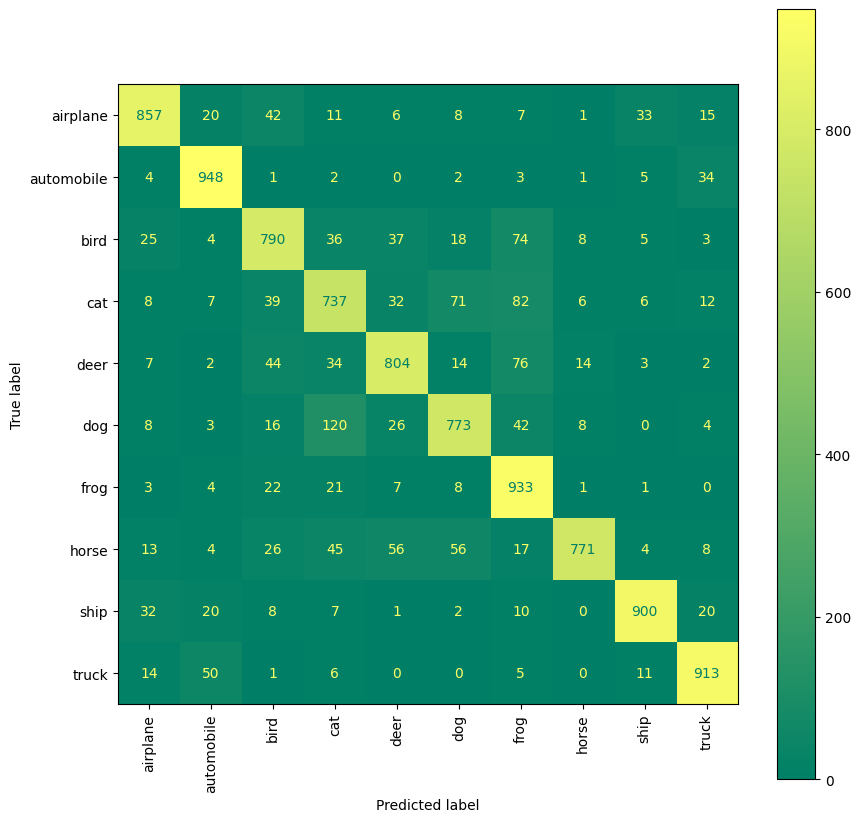

In [19]:
evaluation = model.evaluate(X_test, y_cat_test)
print(f'Test Accuracy : {evaluation[1] * 100:.2f}%')

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred)


disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)


fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax,cmap='summer')

plt.show()

In [27]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87      1000
           1       0.89      0.95      0.92      1000
           2       0.80      0.79      0.79      1000
           3       0.72      0.74      0.73      1000
           4       0.83      0.80      0.82      1000
           5       0.81      0.77      0.79      1000
           6       0.75      0.93      0.83      1000
           7       0.95      0.77      0.85      1000
           8       0.93      0.90      0.91      1000
           9       0.90      0.91      0.91      1000

    accuracy                           0.84     10000
   macro avg       0.85      0.84      0.84     10000
weighted avg       0.85      0.84      0.84     10000



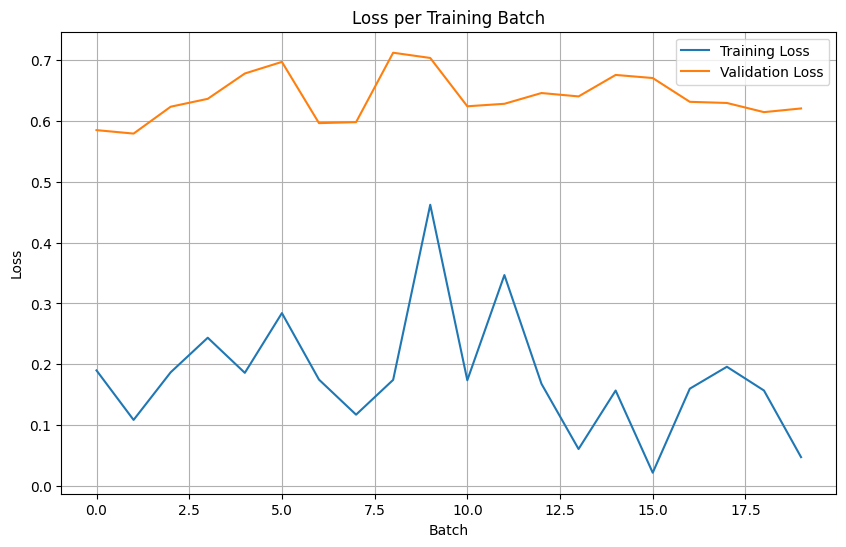

In [28]:
train_loss = r.history['loss']
val_loss = r.history['val_loss']

# Plotting loss for each batch
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss per Training Batch')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

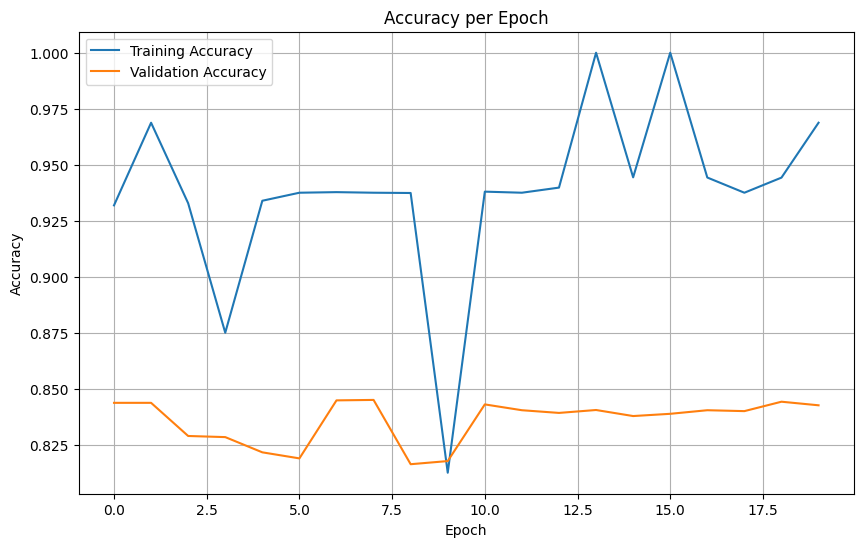

In [29]:
# Extracting accuracy values
train_acc = r.history['accuracy']
val_acc = r.history['val_accuracy']

# Plotting training and validation accuracy per epoch
plt.figure(figsize=(10, 6))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [21]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel(f"{labels[int(predicted_label)]} {100*np.max(predictions_array):2.0f}% ({labels[int(true_label)]})", 
               color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, int(true_label[i])
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


<ipython-input-21-83eb910e855a>:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.xlabel(f"{labels[int(predicted_label)]} {100*np.max(predictions_array):2.0f}% ({labels[int(true_label)]})",
<ipython-input-21-83eb910e855a>:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predictions_array, true_label = predictions_array, int(true_label[i])


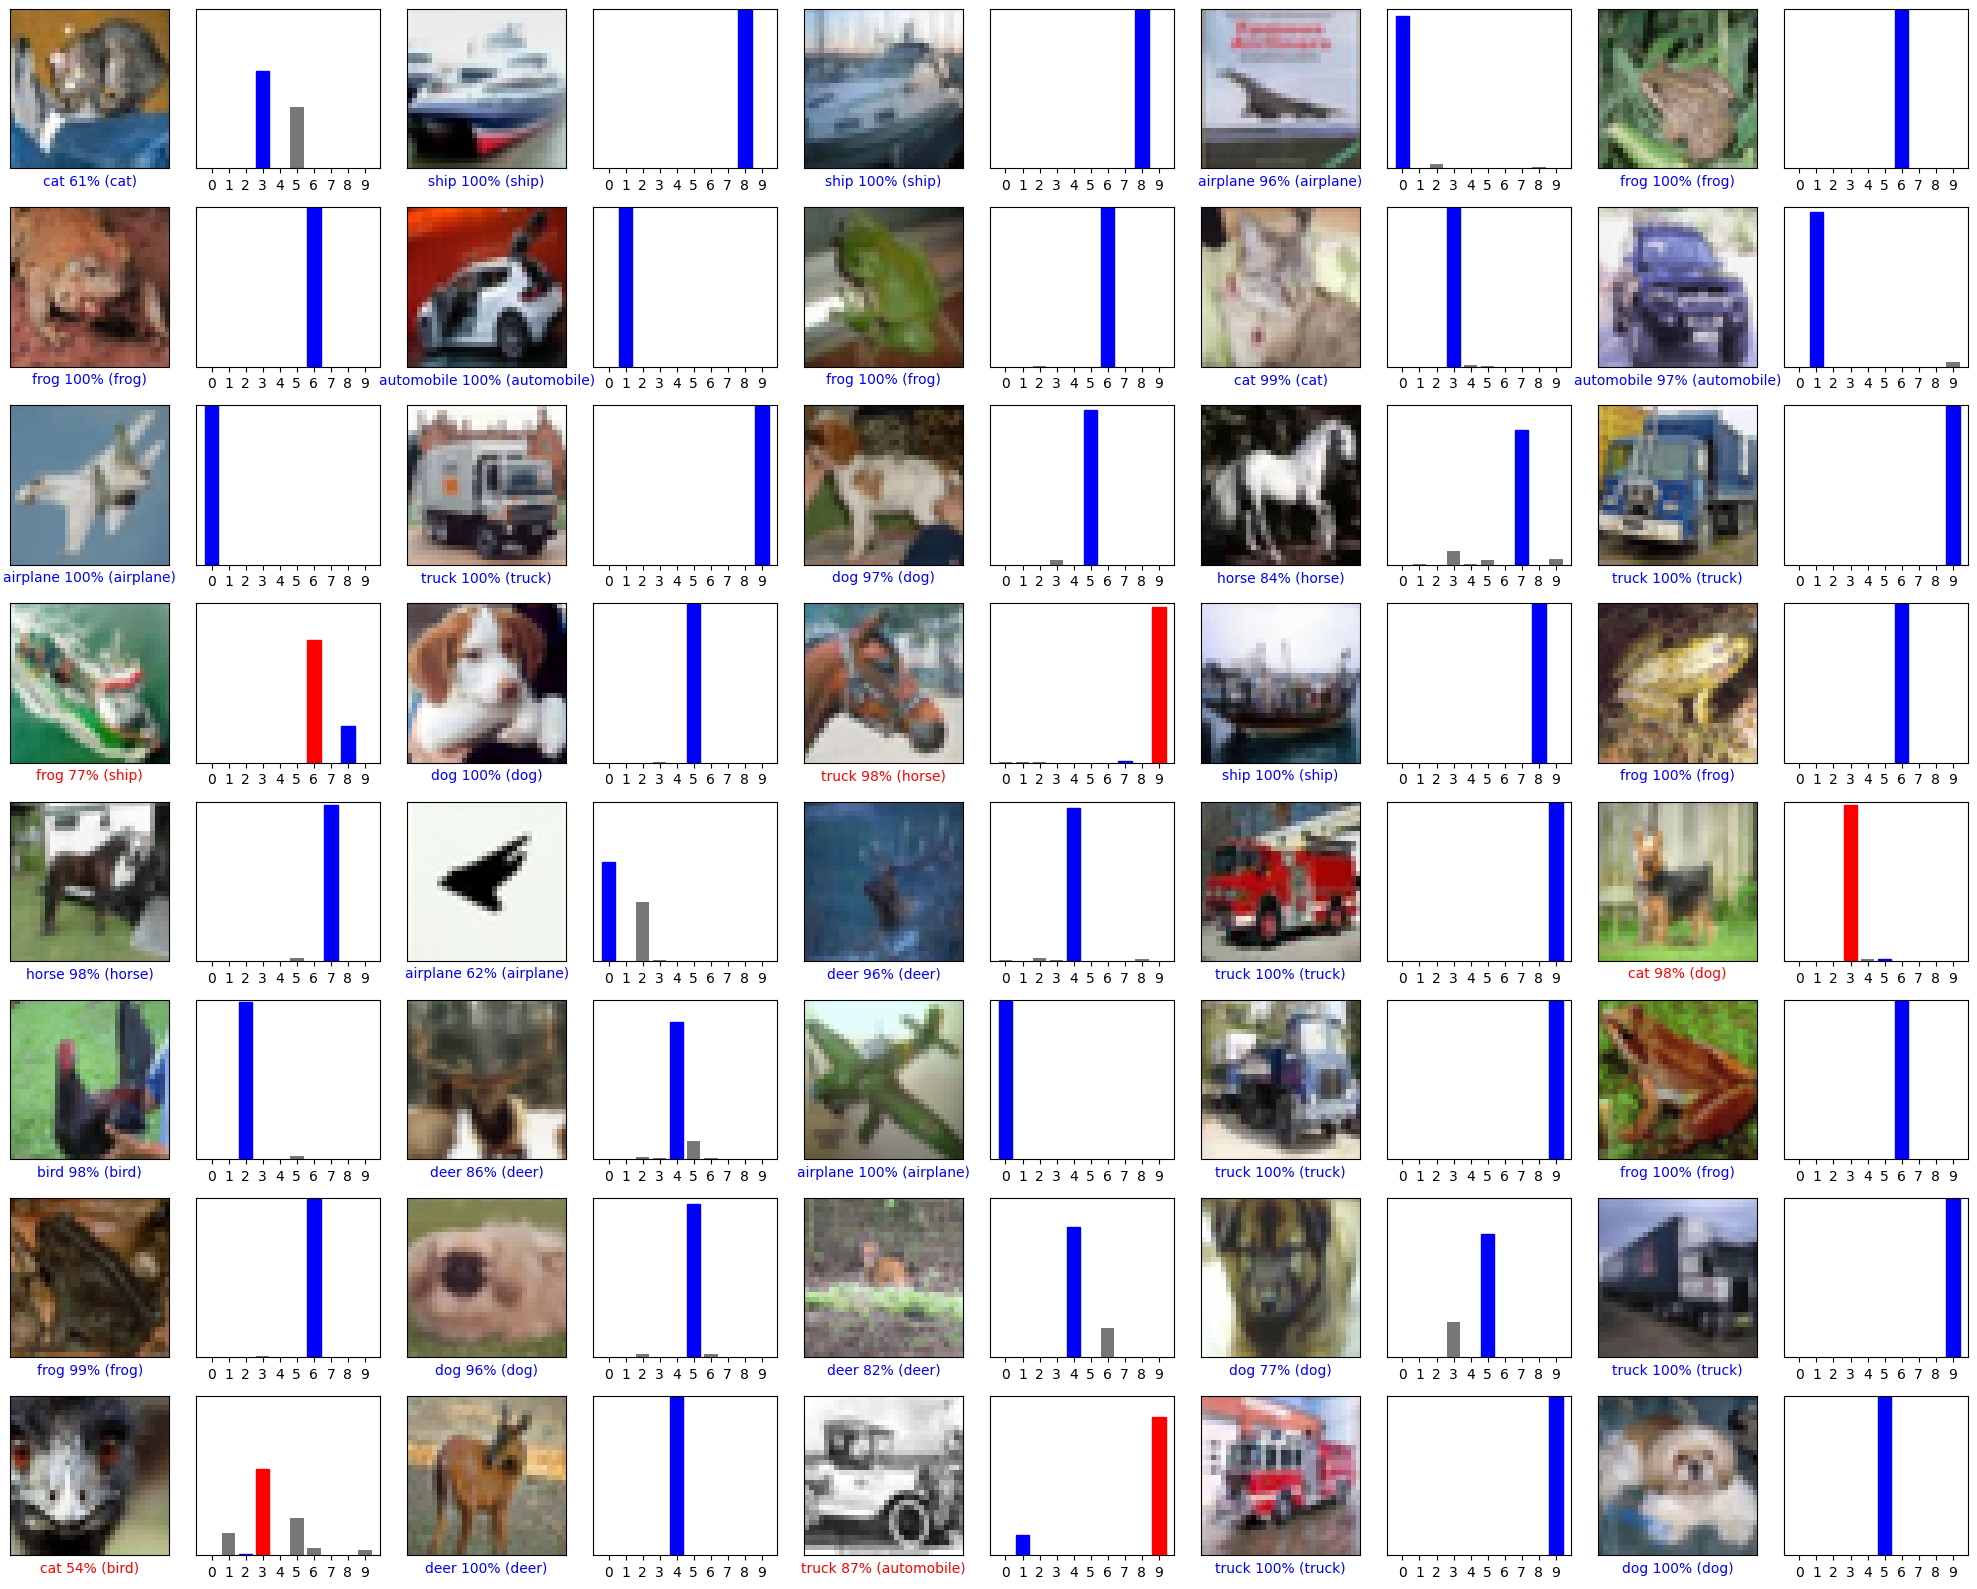

In [30]:
predictions = model.predict(X_test)

# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 8
num_cols = 5
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))

for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_image(i, predictions[i], y_test, X_test)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], y_test)
plt.tight_layout()
plt.show()